In [ ]:
from google.colab import auth
auth.authenticate_user()
import requests
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

NOTE for Granger Causality test:
The row are the response (y) and the columns are the predictors (x). 
If a given p-value is < significance level (0.05), for example, take the value in (row 1, column 2), 
we can reject the null hypothesis and conclude that x Granger causes y, i.e., the col_variable Granger causes the row_variable
Likewise, a value > 0.05 refers to col_variable does not Granger cause the row_variable.


Causality with Stock Rise


In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

sheetname="Hate Score & Stock CDP Binary & Z-score" # Enter Sheet name without using extention
sh = gc.open(sheetname)
worksheet = sh.sheet1
sheets = worksheet.get_all_values()

df = pd.DataFrame(sheets[10:], columns=sheets[0])
df = df[['HS', 'Stock']]

for i in range (0,len(df['Stock'])-1):
  if (df['Stock'][i]=='NaN'):
    df['Stock'][i]=np.nan

df.tail()
#152 last element

,HS,Stock
139,0,0
140,0,0
141,0,0
142,0.784312603,0
143,0.612440383,0


In [ ]:
# data = df
# data.isnull().sum()
# data.isnull().sum()/len(data)

# Replace NaN values with rolling mean of data
df['Stock']=df['Stock'].fillna((df['Stock'].rolling(min_periods=1, center=True, window=7).mean()))

# df.head(27)

In [ ]:
# ADF test to check stationarity

# df = df.drop(['Date'], axis=1)

n_obs = 100
df_train, df_test = df[0:-n_obs], df[-n_obs:]

from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values, autolag='AIC') #adfuller will choose a the number of lags that yields the lowest AIC
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
print('ADF Test: Hate time series')
adf_test(df_train['HS'].astype(float))
print('ADF Test: Stock time series')
adf_test(df_train['Stock'].astype(float))

# If p-value < 0.05 we reject the null hypothesis, i.e, data is stationary
# else if p-value > 0.05 we are unable to reject the null hypothesis i.e, data is non-stationary

ADF Test: Hate time series
ADF Statistics: -3.917986
p-value: 0.001906
Critical values:
	1%: -3.593
	5%: -2.932
	10%: -2.604
ADF Test: Stock time series
ADF Statistics: -2.085346
p-value: 0.250448
Critical values:
	1%: -3.597
	5%: -2.933
	10%: -2.605


In [ ]:
# KPSS test to check stationarity around a mean

from statsmodels.tsa.stattools import kpss

def kpss_test(df):    
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
        
print('KPSS Test: Hate time series')
kpss_test(df_train['HS'].astype(float))
print('KPSS Test: Stock time series')
kpss_test(df_train['Stock'].astype(float))

# If p-value < 0.05 we reject the null hypothesis, i.e, data is non-stationary
#else if p-value > 0.05 we select the null hypothesis i.e, data is stationary
#A key difference from ADF test is the null hypothesis of the KPSS test is that the series is stationary

KPSS Test: Hate time series
KPSS Statistic: 0.341655703691674
p-value: 0.1
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Stock time series
KPSS Statistic: 0.28874003355969646
p-value: 0.1
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
df_train['HS'] = df_train['HS'].astype(float)
df_train['Stock'] = df_train['Stock'].astype(float)

df_train_transformed = df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# VAR method (assumes time series are stationary)
from statsmodels.tsa.api import VAR

model = VAR(df_train_transformed.astype(float))
for i in range(0,30):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 0
AIC :  -3.6286401905068377
BIC :  -3.5475406616923713
FPE :  0.026552681633161195
HQIC:  -3.598564575542676 

Lag Order = 1
AIC :  -4.082065429470546
BIC :  -3.8363165761179556
FPE :  0.01688024438453881
HQIC:  -3.99144084728063 

Lag Order = 2
AIC :  -4.06596059973697
BIC :  -3.65222973824093
FPE :  0.017185458345263405
HQIC:  -3.9143118756868134 

Lag Order = 3
AIC :  -3.9213511620907426
BIC :  -3.336228992972199
FPE :  0.01994858593168762
HQIC:  -3.7082819286928093 

Lag Order = 4
AIC :  -3.7188661485754886
BIC :  -2.958870394224217
FPE :  0.02464453858831351
HQIC:  -3.4440756817085756 

Lag Order = 5
AIC :  -3.49821209681116
BIC :  -2.559792706686744
FPE :  0.03121738166918448
HQIC:  -3.1615152950177348 

Lag Order = 6
AIC :  -3.298625267299707
BIC :  -2.1781715790658644
FPE :  0.039119011434305254
HQIC:  -2.8999764100768126 

Lag Order = 7
AIC :  -3.415297569658276
BIC :  -2.109147910757554
FPE :  0.03627898391669622
HQIC:  -2.954818635408012 

Lag Order = 8
AIC :  -

LinAlgError: ignored

With Maxlag = 1


In [ ]:
results = model.fit(maxlags=1, ic='aic') #13,1 for least AIC
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Aug, 2021
Time:                     07:19:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.83632
Nobs:                     43.0000    HQIC:                  -3.99144
Log likelihood:          -28.2643    FPE:                  0.0168802
AIC:                     -4.08207    Det(Omega_mle):       0.0147503
--------------------------------------------------------------------
Results for equation HS
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.168553         0.091043            1.851           0.064
L1.HS            0.458019         0.141247            3.243           0.001
L1.Stock         0.033857         0.148696            0.228           0.820

Result

In [ ]:
# The Durbin Watson Test is a measure of autocorrelation in residuals from regression analysis
# A value of 2.0 means that there is no autocorrelation detected in the residuals

from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))  

# If within the range of 1.5 and 2.5, we would consider autocorrelation not to be problematic in this regression model      

HS : 1.8
Stock : 2.39


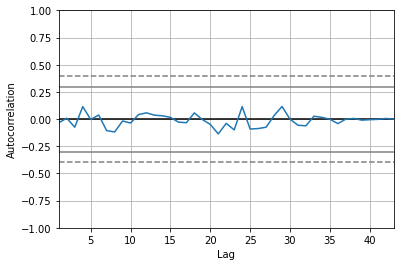

In [ ]:
# Plotting autocorrelation plot for residuals
import matplotlib.pyplot as plt
  
# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(results.resid)
x.plot()
plt.show()

In [ ]:
# Granger Causality

from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 1 # Same maxlag val as b4
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train_transformed, variables = df_train_transformed.columns)


,HS_x,Stock_x
HS_y,1.0000,0.8134
Stock_y,0.5791,1.0000


In [ ]:
# Invert the transformation

lag_order = results.k_ar

df_input = df_train_transformed.values[-lag_order:]
df_forecast = results.forecast(y=df_input, steps=n_obs)
df_forecast = (pd.DataFrame(df_forecast, index=df_test.index, columns=df_test.columns + '_pred'))

def invert_transformation(df, pred):
    forecast = df_forecast.copy()
    columns = df.columns
    for col in columns:
        forecast[str(col)+'_pred'] = df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(df_train, df_forecast)

combined = pd.concat([output['HS_pred'], df_test['HS'], output['Stock_pred'], df_test['Stock']], axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


rmse = mean_squared_error(combined['HS_pred'], combined['HS'], squared=False)
mae = mean_absolute_error(combined['HS_pred'], combined['HS'])

print('Forecast accuracy of Hate')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

rmse = mean_squared_error(combined['Stock_pred'], combined['Stock'], squared=False)
mae = mean_absolute_error(combined['Stock_pred'], combined['Stock'])

print('Forecast accuracy of Stock')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast accuracy of Hate
RMSE:  18.85
MAE:  16.23
Forecast accuracy of Stock
RMSE:  18.72
MAE:  16.11


With Maxlag = 13


In [ ]:
# We select lag order with lowest AIC value

results = model.fit(maxlags=13, ic='aic') #13,1 for least AIC
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Aug, 2021
Time:                     07:22:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.03495
Nobs:                     31.0000    HQIC:                  -4.71860
Log likelihood:           51.7852    FPE:                  0.0255164
AIC:                     -5.53286    Det(Omega_mle):      0.00728931
--------------------------------------------------------------------
Results for equation HS
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             2.669529         0.383017            6.970           0.000
L1.HS            -0.466340         0.184810           -2.523           0.012
L1.Stock          0.133069         0.144377            0.922           0.357
L2

In [ ]:
# The Durbin Watson Test is a measure of autocorrelation in residuals from regression analysis
# A value of 2.0 means that there is no autocorrelation detected in the residuals

from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))  

# If within the range of 1.5 and 2.5, we would consider autocorrelation not to be problematic in this regression model      

HS : 2.46
Stock : 1.99


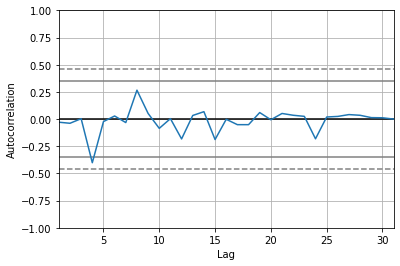

In [ ]:
# Plotting autocorrelation plot for residuals
import matplotlib.pyplot as plt
  
# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(results.resid)
x.plot()
plt.show()

In [ ]:
# Granger Causality

from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 13 # Same maxlag val as b4
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train_transformed, variables = df_train_transformed.columns)


,HS_x,Stock_x
HS_y,1.0,0.0
Stock_y,0.0,1.0


In [ ]:
# Using Max lag = 1
# Here, we accept the null hypothesis that Stock_x does not Granger cause HS_y & Stock_y does not Granger cause HS_x.

# Using Max lag = 13
# Stock_x Granger causes HS_y & Stock_y Granger causes HS_x.
# But the forecast error is larger using max lag = 13 


In [ ]:
# Invert the transformation

lag_order = results.k_ar

df_input = df_train_transformed.values[-lag_order:]
df_forecast = results.forecast(y=df_input, steps=n_obs)
df_forecast = (pd.DataFrame(df_forecast, index=df_test.index, columns=df_test.columns + '_pred'))

def invert_transformation(df, pred):
    forecast = df_forecast.copy()
    columns = df.columns
    for col in columns:
        forecast[str(col)+'_pred'] = df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(df_train, df_forecast)

combined = pd.concat([output['HS_pred'], df_test['HS'], output['Stock_pred'], df_test['Stock']], axis=1)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


rmse = mean_squared_error(combined['HS_pred'], combined['HS'], squared=False)
mae = mean_absolute_error(combined['HS_pred'], combined['HS'])

print('Forecast accuracy of Hate')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

rmse = mean_squared_error(combined['Stock_pred'], combined['Stock'], squared=False)
mae = mean_absolute_error(combined['Stock_pred'], combined['Stock'])

print('Forecast accuracy of Stock')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast accuracy of Hate
RMSE:  113.28
MAE:  60.63
Forecast accuracy of Stock
RMSE:  309.8
MAE:  176.92


Causality with Stock Fall

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

sheetname="Hate Score & Stock CDP Binary & Z-score" # Enter Sheet name without using extention
sh = gc.open(sheetname)
worksheet = sh.sheet1
sheets = worksheet.get_all_values()

df = pd.DataFrame(sheets[10:], columns=sheets[0])
df = df[['HS', 'Stock_fall']]

for i in range (0,len(df['Stock_fall'])-1):
  if (df['Stock_fall'][i]=='Nan'):
    df['Stock_fall'][i]=np.nan

df.tail(10)

,HS,Stock_fall
134,0.003117783,0
135,0.181173301,0.439497787
136,0.099521548,0.746324625
137,0,NaN
138,0,NaN
139,0,0.27789324
140,0,0.360369006
141,0,0
142,0.784312603,0
143,0.612440383,0


In [ ]:
# Replace NaN values with rolling mean of data
df['Stock_fall']=df['Stock_fall'].fillna((df['Stock_fall'].rolling(min_periods=1, center=True, window=7).mean()))

# df.head(27)

In [ ]:
# ADF test to check stationarity

# df = df.drop(['Date'], axis=1)

n_obs = 100
df_train, df_test = df[0:-n_obs], df[-n_obs:]

from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result = adfuller(df.values, autolag='AIC') #adfuller will choose a the number of lags that yields the lowest AIC
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
print('ADF Test: Hate time series')
adf_test(df_train['HS'].astype(float))
print('ADF Test: Stock time series')
adf_test(df_train['Stock_fall'].astype(float))

# If p-value < 0.05 we reject the null hypothesis, i.e, data is stationary
# else if p-value > 0.05 we are unable to reject the null hypothesis i.e, data is non-stationary

ADF Test: Hate time series
ADF Statistics: -3.917986
p-value: 0.001906
Critical values:
	1%: -3.593
	5%: -2.932
	10%: -2.604
ADF Test: Stock time series
ADF Statistics: -1.794517
p-value: 0.383187
Critical values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


In [ ]:
# KPSS test to check stationarity around a mean

from statsmodels.tsa.stattools import kpss

def kpss_test(df):    
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
        
print('KPSS Test: Hate time series')
kpss_test(df_train['HS'].astype(float))
print('KPSS Test: Stock time series')
kpss_test(df_train['Stock_fall'].astype(float))

# If p-value < 0.05 we reject the null hypothesis, i.e, data is non-stationary
#else if p-value > 0.05 we select the null hypothesis i.e, data is stationary
#A key difference from ADF test is the null hypothesis of the KPSS test is that the series is stationary

KPSS Test: Hate time series
KPSS Statistic: 0.341655703691674
p-value: 0.1
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Stock time series
KPSS Statistic: 0.40169971045593394
p-value: 0.0764225385965802
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [ ]:
#We make the series stationary by differencing if the series appears non stationary from the ADF & KPSS tests
# The Stock_fall column is non-stationary here

a = df_train['HS'][0]
b = df_train['Stock_fall'][0]

df_train['HS'] = df_train['HS'].astype(float).diff(1)
df_train['Stock_fall'] = df_train['Stock_fall'].astype(float).diff(1)

df_train_transformed = df_train
df_train_transformed['HS'][0] = a
df_train_transformed['Stock_fall'][0] = b

print('ADF Test: Hate time series')
adf_test(df_train_transformed['HS'])
print('ADF Test: Stock Rise time series')
adf_test(df_train_transformed['Stock_fall'].astype(float))

print('KPSS Test: Hate time series')
kpss_test(df_train_transformed['HS'].astype(float))
print('KPSS Test: Stock Fall time series')
kpss_test(df_train_transformed['Stock_fall'].astype(float))


ADF Test: Hate time series
ADF Statistics: -7.129848
p-value: 0.000000
Critical values:
	1%: -3.593
	5%: -2.932
	10%: -2.604
ADF Test: Stock Rise time series
ADF Statistics: -7.568496
p-value: 0.000000
Critical values:
	1%: -3.597
	5%: -2.933
	10%: -2.605
KPSS Test: Hate time series
KPSS Statistic: 0.19275938156259992
p-value: 0.1
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Stock Fall time series
KPSS Statistic: 0.17532999655644801
p-value: 0.1
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [ ]:
# df_train['HS'] = df_train['HS'].astype(float)
# df_train['Stock_fall'] = df_train['Stock_fall'].astype(float)

# df_train_transformed = df_train

In [ ]:
# VAR method (assumes time series are stationary)
from statsmodels.tsa.api import VAR

model = VAR(df_train_transformed.astype(float))
for i in range(0,30):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 0
AIC :  -3.595267183355941
BIC :  -3.5141676545414744
FPE :  0.02745377696573976
HQIC:  -3.565191568391779 

Lag Order = 1
AIC :  -3.8848628560878713
BIC :  -3.639114002735281
FPE :  0.02055998148810832
HQIC:  -3.7942382738979554 

Lag Order = 2
AIC :  -3.890566637174353
BIC :  -3.476835775678313
FPE :  0.02048017906925351
HQIC:  -3.7389179131241965 

Lag Order = 3
AIC :  -4.0895976013192605
BIC :  -3.5044754322007163
FPE :  0.016859458270000443
HQIC:  -3.8765283679213267 

Lag Order = 4
AIC :  -3.9175743364409468
BIC :  -3.157578582089675
FPE :  0.02020332368618472
HQIC:  -3.6427838695740338 

Lag Order = 5
AIC :  -4.009208171248984
BIC :  -3.0707887811245675
FPE :  0.018727236659379823
HQIC:  -3.6725113694555582 

Lag Order = 6
AIC :  -4.04627805947969
BIC :  -2.925824371245847
FPE :  0.01852193642954973
HQIC:  -3.647629202256795 

Lag Order = 7
AIC :  -3.876435258008974
BIC :  -2.570285599108252
FPE :  0.022876288325080617
HQIC:  -3.41595632375871 

Lag Order = 8
AIC : 

With lag order 3


In [ ]:
results = model.fit(maxlags=3, ic='aic') # 3 for least AIC between lag order 0-7
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Aug, 2021
Time:                     07:25:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.50448
Nobs:                     41.0000    HQIC:                  -3.87653
Log likelihood:          -18.5162    FPE:                  0.0168595
AIC:                     -4.08960    Det(Omega_mle):       0.0123007
--------------------------------------------------------------------
Results for equation HS
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.024461         0.061369           -0.399           0.690
L1.HS                -0.164825         0.147012           -1.121           0.262
L1.Stock_fall         0.001603         0.222947            0.00

In [ ]:
# The Durbin Watson Test is a measure of autocorrelation in residuals from regression analysis
# A value of 2.0 means that there is no autocorrelation detected in the residuals

from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))  

# If within the range of 1.5 and 2.5, we would consider autocorrelation not to be problematic in this regression model      

HS : 2.07
Stock_fall : 1.92


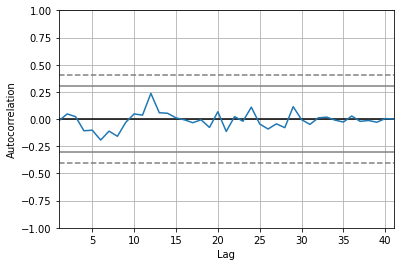

In [ ]:
# Plotting autocorrelation plot for residuals
import matplotlib.pyplot as plt
  
# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(results.resid)
x.plot()
plt.show()

In [ ]:
# Granger Causality

from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 3 # Same maxlag val as b4
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train_transformed, variables = df_train_transformed.columns)


,HS_x,Stock_fall_x
HS_y,1.0000,0.1745
Stock_fall_y,0.2237,1.0000


In [ ]:
# Invert the transformation

lag_order = results.k_ar

df_input = df_train_transformed.values[-lag_order:]
df_forecast = results.forecast(y=df_input, steps=n_obs)
df_forecast = (pd.DataFrame(df_forecast, index=df_test.index, columns=df_test.columns + '_pred'))

def invert_transformation(df, pred):
    forecast = df_forecast.copy()
    columns = df.columns
    for col in columns:
        forecast[str(col)+'_pred'] = df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(df_train, df_forecast)

combined = pd.concat([output['HS_pred'], df_test['HS'], output['Stock_fall_pred'], df_test['Stock_fall']], axis=1)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


rmse = mean_squared_error(combined['HS_pred'], combined['HS'], squared=False)
mae = mean_absolute_error(combined['HS_pred'], combined['HS'])

print('Forecast accuracy of Hate')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

rmse = mean_squared_error(combined['Stock_fall_pred'], combined['Stock_fall'], squared=False)
mae = mean_absolute_error(combined['Stock_fall_pred'], combined['Stock_fall'])

print('Forecast accuracy of Stock')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast accuracy of Hate
RMSE:  1.08
MAE:  0.94
Forecast accuracy of Stock
RMSE:  1.61
MAE:  1.51


With lag order = 8


In [ ]:
results = model.fit(maxlags=8, ic='aic') # 3 for least AIC between lag order 0-7
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Aug, 2021
Time:                     07:26:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.72030
Nobs:                     36.0000    HQIC:                  -3.69386
Log likelihood:           7.72162    FPE:                  0.0173697
AIC:                     -4.21584    Det(Omega_mle):      0.00801394
--------------------------------------------------------------------
Results for equation HS
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.136372         0.063388           -2.151           0.031
L1.HS                -0.450881         0.191934           -2.349           0.019
L1.Stock_fall         0.051687         0.241156            0.21

In [ ]:
# The Durbin Watson Test is a measure of autocorrelation in residuals from regression analysis
# A value of 2.0 means that there is no autocorrelation detected in the residuals

from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))  

# If within the range of 1.5 and 2.5, we would consider autocorrelation not to be problematic in this regression model 

HS : 2.2
Stock_fall : 1.62


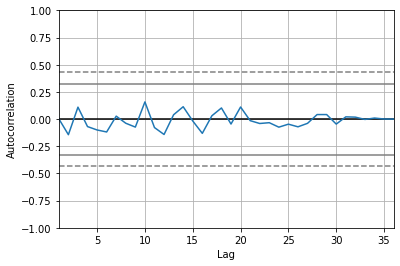

In [ ]:
# Plotting autocorrelation plot for residuals
import matplotlib.pyplot as plt
  
# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(results.resid)
x.plot()
plt.show()

In [ ]:
# Granger Causality

from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 8 # Same maxlag val as b4
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train_transformed, variables = df_train_transformed.columns)

,HS_x,Stock_fall_x
HS_y,1.0000,0.0
Stock_fall_y,0.0027,1.0


In [ ]:
# Invert the transformation

lag_order = results.k_ar

df_input = df_train_transformed.values[-lag_order:]
df_forecast = results.forecast(y=df_input, steps=n_obs)
df_forecast = (pd.DataFrame(df_forecast, index=df_test.index, columns=df_test.columns + '_pred'))

def invert_transformation(df, pred):
    forecast = df_forecast.copy()
    columns = df.columns
    for col in columns:
        forecast[str(col)+'_pred'] = df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(df_train, df_forecast)

combined = pd.concat([output['HS_pred'], df_test['HS'], output['Stock_fall_pred'], df_test['Stock_fall']], axis=1)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


rmse = mean_squared_error(combined['HS_pred'], combined['HS'], squared=False)
mae = mean_absolute_error(combined['HS_pred'], combined['HS'])

print('Forecast accuracy of Hate')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

rmse = mean_squared_error(combined['Stock_fall_pred'], combined['Stock_fall'], squared=False)
mae = mean_absolute_error(combined['Stock_fall_pred'], combined['Stock_fall'])

print('Forecast accuracy of Stock')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast accuracy of Hate
RMSE:  2.94
MAE:  2.69
Forecast accuracy of Stock
RMSE:  0.78
MAE:  0.73


Try Granger Causality without differencing time series

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

sheetname="Hate Score & Stock CDP Binary & Z-score" # Enter Sheet name without using extention
sh = gc.open(sheetname)
worksheet = sh.sheet1
sheets = worksheet.get_all_values()

df = pd.DataFrame(sheets[10:], columns=sheets[0])
df = df[['HS', 'Stock_fall']]

for i in range (0,len(df['Stock_fall'])-1):
  if (df['Stock_fall'][i]=='Nan'):
    df['Stock_fall'][i]=np.nan

df.tail(10)

,HS,Stock_fall
134,0.003117783,0
135,0.181173301,0.439497787
136,0.099521548,0.746324625
137,0,NaN
138,0,NaN
139,0,0.27789324
140,0,0.360369006
141,0,0
142,0.784312603,0
143,0.612440383,0


In [ ]:
df['Stock_fall']=df['Stock_fall'].fillna((df['Stock_fall'].rolling(min_periods=1, center=True, window=7).mean()))

# df.head(27)

In [ ]:
n_obs = 100
df_train, df_test = df[0:-n_obs], df[-n_obs:]


df_train['HS'] = df_train['HS'].astype(float)
df_train['Stock_fall'] = df_train['Stock_fall'].astype(float)

df_train_transformed = df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# VAR method (assumes time series are stationary)
from statsmodels.tsa.api import VAR

model = VAR(df_train_transformed.astype(float))
for i in range(0,30):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 0
AIC :  -3.618147164686434
BIC :  -3.5370476358719674
FPE :  0.02683276650618338
HQIC:  -3.588071549722272 

Lag Order = 1
AIC :  -4.050982232138989
BIC :  -3.8052333787863986
FPE :  0.01741317605423175
HQIC:  -3.960357649949073 

Lag Order = 2
AIC :  -4.3588867698094225
BIC :  -3.9451559083133825
FPE :  0.01282167901228513
HQIC:  -4.207238045759266 

Lag Order = 3
AIC :  -4.366248215955387
BIC :  -3.7811260468368424
FPE :  0.012784854221131356
HQIC:  -4.153178982557453 

Lag Order = 4
AIC :  -4.2225690942557765
BIC :  -3.4625733399045053
FPE :  0.014892420198106457
HQIC:  -3.947778627388864 

Lag Order = 5
AIC :  -3.9938375922045286
BIC :  -3.0554182020801126
FPE :  0.01901730870752476
HQIC:  -3.6571407904111033 

Lag Order = 6
AIC :  -3.9150369942191565
BIC :  -2.794583305985314
FPE :  0.021119501341685016
HQIC:  -3.516388136996262 

Lag Order = 7
AIC :  -4.071192026955509
BIC :  -2.765042368054787
FPE :  0.01882798187452534
HQIC:  -3.610713092705245 

Lag Order = 8
AIC 

LinAlgError: ignored

With maxlag = 3 & 7

In [ ]:
results = model.fit(maxlags=3, ic='aic') # 3 for least AIC between lag order 0-6
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Aug, 2021
Time:                     07:27:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.94516
Nobs:                     42.0000    HQIC:                  -4.20724
Log likelihood:          -17.6542    FPE:                  0.0128217
AIC:                     -4.35889    Det(Omega_mle):       0.0102388
--------------------------------------------------------------------
Results for equation HS
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.209599         0.092521            2.265           0.023
L1.HS                 0.557596         0.158651            3.515           0.000
L1.Stock_fall         0.197838         0.188003            1.05

In [ ]:
# The Durbin Watson Test is a measure of autocorrelation in residuals from regression analysis
# A value of 2.0 means that there is no autocorrelation detected in the residuals

from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))  

# If within the range of 1.5 and 2.5, we would consider autocorrelation not to be problematic in this regression model 

HS : 1.92
Stock_fall : 2.36


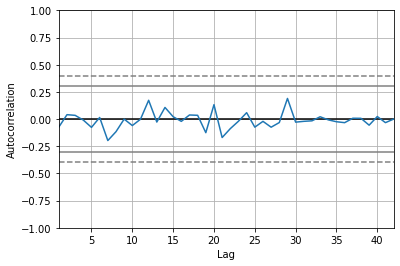

In [ ]:
# Plotting autocorrelation plot for residuals
import matplotlib.pyplot as plt
  
# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(results.resid)
x.plot()
plt.show()

In [ ]:
# Granger Causality

from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 3 # Same maxlag val as b4
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train_transformed, variables = df_train_transformed.columns)

,HS_x,Stock_fall_x
HS_y,1.0000,0.5334
Stock_fall_y,0.0531,1.0000


In [ ]:
lag_order = results.k_ar

df_input = df_train_transformed.values[-lag_order:]
df_forecast = results.forecast(y=df_input, steps=n_obs)
df_forecast = (pd.DataFrame(df_forecast, index=df_test.index, columns=df_test.columns + '_pred'))

def invert_transformation(df, pred):
    forecast = df_forecast.copy()
    columns = df.columns
    for col in columns:
        forecast[str(col)+'_pred'] = df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(df_train, df_forecast)

combined = pd.concat([output['HS_pred'], df_test['HS'], output['Stock_fall_pred'], df_test['Stock_fall']], axis=1)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


rmse = mean_squared_error(combined['HS_pred'], combined['HS'], squared=False)
mae = mean_absolute_error(combined['HS_pred'], combined['HS'])

print('Forecast accuracy of Hate')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

rmse = mean_squared_error(combined['Stock_fall_pred'], combined['Stock_fall'], squared=False)
mae = mean_absolute_error(combined['Stock_fall_pred'], combined['Stock_fall'])

print('Forecast accuracy of Stock')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))


Forecast accuracy of Hate
RMSE:  18.87
MAE:  16.3
Forecast accuracy of Stock
RMSE:  14.19
MAE:  12.34


Differencing only the Stock fall column

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

sheetname="Hate Score & Stock CDP Binary & Z-score" # Enter Sheet name without using extention
sh = gc.open(sheetname)
worksheet = sh.sheet1
sheets = worksheet.get_all_values()

df = pd.DataFrame(sheets[10:], columns=sheets[0])
df = df[['HS', 'Stock_fall']]

for i in range (0,len(df['Stock_fall'])-1):
  if (df['Stock_fall'][i]=='Nan'):
    df['Stock_fall'][i]=np.nan

df.tail(10)

,HS,Stock_fall
134,0.003117783,0
135,0.181173301,0.439497787
136,0.099521548,0.746324625
137,0,NaN
138,0,NaN
139,0,0.27789324
140,0,0.360369006
141,0,0
142,0.784312603,0
143,0.612440383,0


In [ ]:
df['Stock_fall']=df['Stock_fall'].fillna((df['Stock_fall'].rolling(min_periods=1, center=True, window=7).mean()))

# df.head(27)

In [ ]:
n_obs = 100
df_train, df_test = df[0:-n_obs], df[-n_obs:]


In [ ]:
#We make the series stationary by differencing if the series appears non stationary from the ADF & KPSS tests
# a = df_train['HS'][0]
b = df_train['Stock_fall'][0]

df_train['HS'] = df_train['HS'].astype(float)
df_train['Stock_fall'] = df_train['Stock_fall'].astype(float).diff(1)

df_train_transformed = df_train
# df_train_transformed['HS'][0] = a
df_train_transformed['Stock_fall'][0] = b

print('ADF Test: Hate time series')
adf_test(df_train_transformed['HS'].astype(float))
print('ADF Test: Stock Rise time series')
adf_test(df_train_transformed['Stock_fall'].astype(float))

print('KPSS Test: Hate time series')
kpss_test(df_train_transformed['HS'].astype(float))
print('KPSS Test: Stock Fall time series')
kpss_test(df_train_transformed['Stock_fall'].astype(float))


ADF Test: Hate time series
ADF Statistics: -3.917986
p-value: 0.001906
Critical values:
	1%: -3.593
	5%: -2.932
	10%: -2.604
ADF Test: Stock Rise time series
ADF Statistics: -7.568496
p-value: 0.000000
Critical values:
	1%: -3.597
	5%: -2.933
	10%: -2.605
KPSS Test: Hate time series
KPSS Statistic: 0.341655703691674
p-value: 0.1
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
KPSS Test: Stock Fall time series
KPSS Statistic: 0.17532999655644801
p-value: 0.1
num lags: 10
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [ ]:
# VAR method (assumes time series are stationary)
from statsmodels.tsa.api import VAR

model = VAR(df_train_transformed.astype(float))
for i in range(0,30):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 0
AIC :  -3.661603794605753
BIC :  -3.5805042657912867
FPE :  0.02569167839534432
HQIC:  -3.6315281796415912 

Lag Order = 1
AIC :  -4.172910692907485
BIC :  -3.9271618395548944
FPE :  0.01541434706595218
HQIC:  -4.082286110717569 

Lag Order = 2
AIC :  -4.252942833760237
BIC :  -3.839211972264197
FPE :  0.01425462402646021
HQIC:  -4.10129410971008 

Lag Order = 3
AIC :  -4.271175514263251
BIC :  -3.686053345144707
FPE :  0.014060000304420572
HQIC:  -4.058106280865317 

Lag Order = 4
AIC :  -4.095014569254721
BIC :  -3.3350188149034494
FPE :  0.016918486451880967
HQIC:  -3.820224102387808 

Lag Order = 5
AIC :  -4.096479779666854
BIC :  -3.1580603895424377
FPE :  0.017162166888065742
HQIC:  -3.7597829778734284 

Lag Order = 6
AIC :  -3.910121036038375
BIC :  -2.7896673478045324
FPE :  0.021223579539512066
HQIC:  -3.5114721788154806 

Lag Order = 7
AIC :  -3.998346573520263
BIC :  -2.692196914619541
FPE :  0.020250705132138565
HQIC:  -3.537867639269999 

Lag Order = 8
AIC : 

With Maxlag = 3, 8

In [ ]:
results = model.fit(maxlags=3, ic='aic') # 3 for least AIC between lag order 0-7
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 24, Aug, 2021
Time:                     07:29:33
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.83921
Nobs:                     42.0000    HQIC:                  -4.10129
Log likelihood:          -19.8790    FPE:                  0.0142546
AIC:                     -4.25294    Det(Omega_mle):       0.0113830
--------------------------------------------------------------------
Results for equation HS
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.230536         0.080727            2.856           0.004
L1.HS                 0.564835         0.159576            3.540           0.000
L1.Stock_fall         0.156186         0.194818            0.80

In [ ]:
# The Durbin Watson Test is a measure of autocorrelation in residuals from regression analysis
# A value of 2.0 means that there is no autocorrelation detected in the residuals

from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))  

# If within the range of 1.5 and 2.5, we would consider autocorrelation not to be problematic in this regression model 

HS : 1.89
Stock_fall : 2.19


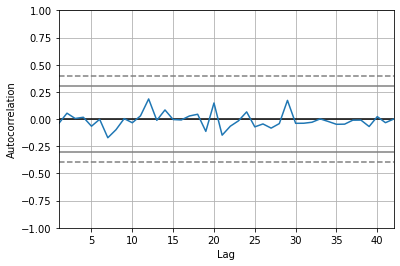

In [ ]:
# Plotting autocorrelation plot for residuals
import matplotlib.pyplot as plt
  
# Creating Autocorrelation plot
x = pd.plotting.autocorrelation_plot(results.resid)
x.plot()
plt.show()

In [ ]:
# Granger Causality

from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 3 # Same maxlag val as b4
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_train_transformed, variables = df_train_transformed.columns)

,HS_x,Stock_fall_x
HS_y,1.0000,0.1193
Stock_fall_y,0.2949,1.0000


In [ ]:
lag_order = results.k_ar

df_input = df_train_transformed.values[-lag_order:]
df_forecast = results.forecast(y=df_input, steps=n_obs)
df_forecast = (pd.DataFrame(df_forecast, index=df_test.index, columns=df_test.columns + '_pred'))

def invert_transformation(df, pred):
    forecast = df_forecast.copy()
    columns = df.columns
    for col in columns:
        forecast[str(col)+'_pred'] = df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast
output = invert_transformation(df_train, df_forecast)

combined = pd.concat([output['HS_pred'], df_test['HS'], output['Stock_fall_pred'], df_test['Stock_fall']], axis=1)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


rmse = mean_squared_error(combined['HS_pred'], combined['HS'], squared=False)
mae = mean_absolute_error(combined['HS_pred'], combined['HS'])

print('Forecast accuracy of Hate')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

rmse = mean_squared_error(combined['Stock_fall_pred'], combined['Stock_fall'], squared=False)
mae = mean_absolute_error(combined['Stock_fall_pred'], combined['Stock_fall'])

print('Forecast accuracy of Stock')
print('RMSE: ', round(rmse,2))
print('MAE: ', round(mae,2))

Forecast accuracy of Hate
RMSE:  19.24
MAE:  16.61
Forecast accuracy of Stock
RMSE:  1.37
MAE:  1.3
